In [1]:
import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import scipy

from numcosmo_py import Nc, Ncm

%matplotlib inline

In [2]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

## Primordial black holes formation in  dust-flat bounce
In this notebook we develop the necessary objects to compute the power spectrum (and other observables) for magnetic field production in the contraction phase of a bouncing cosmology dominated by a dust-like fluid.
    The scale factor for this model is given by,
    \begin{equation},
    \frac{a(t)}{a_0} = \frac{1}{x_b}\left[1 + \left(\frac{t}{t_b}\right)^2\right]^{1/3}, \quad x \equiv \frac{a_0}{a}, \quad x_b \equiv \frac{a_0}{a_b}
    \end{equation} ,
    where $a_b$ gives the value of the scale factor at the bounce ($t = 0$), and $t_b$ the bounce time-scale. Solving the time $t$ in terms of the scale factor and substituting back to the Hubble function we can relate the free parameter $t_b$ with the dimensionless density $\Omega_m$, i.e.
    \begin{equation}
H^2 = \left(\frac{c \dot a}{a}\right)^2 = \frac{4}{9}\frac{x^3}{t_b^2x_b^3} - \frac{4}{9}\frac{x^6}{t_b^2x_b^6} = \frac{1}{R_H^2}\left(\Omega_m x^3 + \Omega_Q x^6\right) \quad\Rightarrow\quad t_b = \frac{2}{3}\frac{R_H}{\sqrt{\Omega_m x_b^3}}, \quad \Omega_Q = - \frac{\Omega_m}{x_b^3}.
\end{equation},
    where $R_H \equiv 1/H_0$ is the Hubble radius today and $\Omega_m$ is the dimensionless matter density today.
    From here on we will express everything in unit of the Hubble radius, $t \to t /R_H$ and $t_b \to t_b / R_H$. 

## Definition of the Numerical Object to compute the equations of motion

### Equations of motion to be solved
This is a python object to solve the equation of motion for zeta, which is
    \begin{equation}
    2 z^2 \dot{\zeta}_{ka} = \Pi_{\zeta, ka}
    \end{equation}
    \begin{equation}
    \dot{\Pi}_{\zeta, ka} = 2 \frac{ka^2}{a^2} w z^2 \zeta_{ka}
 .\end{equation}
In this system, I am using cosmic time. However, we are writting everything in units of $RH$. I am using the dimensionless fields and the dimensionless momentum as $ka = k * RH$. Also here a dot is the derivative of time and im using N=1 and the metric $-dt^2$, so time has the dimension of space.

In [3]:
class PyCSQ1DVecPert (Ncm.CSQ1D):
    def __init__ (self, Omega_m = 0.3, Omega_r = 8.0e-5, xb = 1.0e25, b = 1.0e-6, h = 0.7):
        Ncm.CSQ1D.__init__ (self)

        self.Omega_m = Omega_m
        self.Omega_r = Omega_r
        self.xb      = xb
        self.b       = b
        self.RH      = (Ncm.C.c () / (1.0e5 * h)) # Hubble radius in units of Mpc
        self.RH_m      = (Ncm.C.c () * 3.086e22 / (1.0e5 * h)) # Hubble radius in units of m
        self.gamma   = 0.25 * xb * Omega_m
        self.tb    = 2.0 / (3.0* math.sqrt (Omega_m * xb**3))
        self.lp_RH   = 1.0 / (Ncm.C.hubble_radius_hm1_planck () / h)
        self.hbar = self.lp_RH**2 * Ncm.C.c()**3 / Ncm.C.G()

    
    def y_t (self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))

        return s / self.xb

    def t_y (self, y):
        xb   = self.xb
        yxb3 = math.pow(y * xb, 3)
        s1   = yxb3 - 1

        return math.sqrt (s1) * self.etab

    def H_t (self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb

        x = 1.0/ y_t
        x3 = x**3
        x6 = x**6
        m1    = (4.0/9.0) * (xb**(-3) / tb2)
        s1 = m1*( x3 - x6/ (xb**3))
        return math.sqrt(s1)

    def H_dt(self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        tb2 = self.tb**2
        m1    = (2.0/9.0) * (xb**(-3) / tb2)
        return m1 * ( - 3.0 * x3 + 6 * x6/ (xb**3))

    def H_d2t(self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        x = 1.0/y_t

        x3 = x**3
        x6 = x**6
        mh    = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))
        H = math.sqrt(sh)
        m1    = 2.0 * H * (xb**(-3) / tb2)

        return m1 * ( x3 - 4.0 * x6/ (xb**3))

    def H_d3t(self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        x = 1.0/y_t

        x3 = x**3
        x6 = x**6
        mh    = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))
        mh2t    = 2.0 * H * (xb**(-3) / tb2)
        mht    = (2.0/9.0) * (xb**(-3) / tb2)

        H = math.sqrt(sh)
        H_dt =  mht * ( - 3.0 * x3 + 6 * x6/ (xb**3))
        H_d2t =  mh2t * ( x3 - 4.0 * x6/ (xb**3))



        m1    = 2.0 * H**2 * (xb**(-3) / tb2)

        return (H_dt * H_d2t / H) + m1 * ( -3.0*x3 + 24.0 * x6/ (xb**3))


    def z_y(self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t3 = y_t**3

        return math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
    
    def z_dt(self, t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t3 = y_t**3
        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        tb2 = self.tb**2
        m1    = (2.0/9.0) * (xb**(-3) / tb2)
        H = m1 * ( - 3.0 * x3 + 6 * x6/ (xb**3))

        z_y = math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
        
        return (3.0/2.0) * z_y * H  

    def z_d2t(self,t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
        m1 = (3.0 / 2.0 )

        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        mht = (2.0/9.0) * (xb**(-3) / tb2)
        mh = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))

        H2 = sh
        H_dt =  mht * ( - 3.0 * x3 + 6 * x6/ (xb**3))


        return m1 * z_y * (3.0 * H2 / 2.0 + H_dt) 

    def z_d3t(self,t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
        m1 = (3.0 / 2.0 )

        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        mh    = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))
        mht    = (2.0/9.0) * (xb**(-3) / tb2)

        H = math.sqrt(sh)
        mh2t    = 2.0 * H * (xb**(-3) / tb2)
        H3 = H**3
        H_dt =  mht * ( - 3.0 * x3 + 6 * x6/ (xb**3))
        H_d2t =  mh2t * ( x3 - 4.0 * x6/ (xb**3))


        return m1 * z_y * (9.0 * H3 / 4.0 + (9.0 / 2.0) * H_dt * H + H_d2t) 

    def z_d4t(self,t):
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
        m1 = (3.0 / 2.0 )

        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        tb2 = self.tb**2
        mh    = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))
        mht    = (2.0/9.0) * (xb**(-3) / tb2)

        H = math.sqrt(sh)
        mh2t    = 2.0 * H * (xb**(-3) / tb2)
        mh3t    = 2.0 * H**2 * (xb**(-3) / tb2)
        H2 = H**2
        H4 = H**4
        H_dt =  mht * ( - 3.0 * x3 + 6 * x6/ (xb**3))
        H_d2t =  mh2t * ( x3 - 4.0 * x6/ (xb**3))
        H_d3t (H_dt * H_d2t / H) + mh3t * ( -3.0*x3 + 24.0 * x6/ (xb**3))

        return m1 * z_y * (27.0 * H4 / 4.0 + (27.0 / 2.0) * H_dt * H2 + (9.0/2.0) * H_dt**2 + 6.0 * H_d2t * H + H_d3t) 

    def do_eval_xi (self, model, t, k):
        k2 = k**2
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t2  = y_t**2
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))

        nu = math.sqrt(k2 * self.b / y_t2)
        m = 2.0 * z_y**2
        
        
        return np.log(m * nu)

    def do_eval_nu (self, model, t, k):
        k2 = k**2
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t2  = y_t**2
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))
        
        return math.sqrt(k2 * self.b / y_t2)
        


    def do_eval_F1 (self, model, t, k):
        k2 = k**2
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t2  = y_t**2
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))

        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        mht = (2.0/9.0) * (xb**(-3) / tb2)
        mh = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))

        
        nu = math.sqrt(k2 * self.b / y_t2)
        
        H = math.sqrt(sh)

        return H / nu

    def do_eval_F2 (self, model, t, k):
        k2 = k**2
        t2  = t * t
        tb2 = self.tb**2
        s    = math.pow((1.0 + t2 / tb2),  1.0/(3.0 * (1.0 + self.b)))
        xb   = self.xb
        y_t  = s / xb
        y_t2  = y_t**2
        y_t3 = y_t**3
        z_y= math.sqrt((3.0 /2.0) * y_t3 * ((1.0 + self.b) / self.b))

        x = 1.0/y_t
        x3 = x**3
        x6 = x**6
        mht = (2.0/9.0) * (xb**(-3) / tb2)
        mh = (4.0/9.0) * (xb**(-3) / tb2)
        sh = mh*( x3 - x6/ (xb**3))

        H = math.sqrt(sh)
        nu = math.sqrt(k2 * self.b / y_t2)
        F1 = H / nu
        H_dt =  mht * ( - 3.0 * x3 + 6 * x6/ (xb**3))
        
        
        return 0.5 * F1 * F1 + 0.5 * H_dt / (nu**2)

    def do_prepare (self, model):
        pass 



In [4]:
csq1d = PyCSQ1DVecPert (b = 1.0e-6, xb = 5.0e25)
momenta_rh = np.geomspace(1.0e4, 1.0e9, 4)

In [5]:
conv_tn_t =  6.58e-25 #tn to cosmic time
conv_trh_t = csq1d.RH_m / Ncm.C.c() #t_rh to cosmic time
conv_taun_tau = (0.197e-15) # conformal time in natural units to meters
conv_taun_taurh = (0.197e-15) / csq1d.RH_m # conformal time in natural units to units in RH
conv_deltak_mpc_to_m = (3.08e22)**(3/2) # deltak in MPC to meters
conv_deltan_delta =(0.197e-15)**(3/2)  #deltak in natural units to meters
conv_Hrh_Hn = 0.197e-15/ csq1d.RH_m
#conv_Hrh_Hn = (6.58e-25) * csq1d.RH_m/ Ncm.C.c()  
conv_Hrh_HMpc = 0.197e-15/ csq1d.RH
conv_knat_krh = csq1d.RH_m / (0.197e-15)
conv_tbnat_tbrh =  0.197e-15/ csq1d.RH_m

\begin{align}
\delta_k^2 = \Pi_\zeta^* \zeta\left(\frac{6 h z^2}{a^3 \kappa  (p+\rho )}-\frac{9 h z^2}{a k^2}\right)+\Pi_\zeta \zeta^* \left(\frac{6 h z^2}{a^3 \kappa  (p+\rho )}-\frac{9 h z^2}{a k^2}\right)+\Pi_\zeta^2
\left(\frac{4 h^2 z^4}{a^6 \kappa ^2 (p+\rho )^2}-\frac{12 h^2 z^4}{a^4 \kappa  k^2 (p+\rho )}+\frac{9 h^2 z^4}{a^2 k^4}\right)+9 \zeta^2
\end{align}

In [6]:
def deltak2_numerical(J22, J11, J12, J21, w, h, k, a, z):
    h = h / csq1d.RH
    k = k / csq1d.RH
    a3h2 = a**3 * h
    S1 = J22*(9.0 * h**2 / (4.0 * a**2 * k**4) + 1.0/(9* a3h2**2 * (1 + w)**2) - 1.0/(a**4 * k**2 * (1 + w)))
    S2 = J21*(-(9.0 * h/(2.0 * a * k**2)) + 1.0/(a**3 * h * (1 + w))) 
    S3 = J12*(-(9.0 * h/(2.0 * a * k**2)) + 1.0/(a**3 * h * (1 + w)))
    S4 = 9.0 * J11 
    delta_mpc = (S1+S2+S3+S4)
    return   delta_mpc

from mpmath import mp
import mpmath
def get_adiab_time(k):
    var = []
    beta = []
    max_etaf = -1.0e300
    min_etai = +1.0e300
    csq1d.set_reltol(1.0e-5)
    csq1d.set_k (k)
    (Found1, etai) = csq1d.find_adiab_time_limit(None, -1.0e15, -1.0e-35, 1.0e-7)
    (Found2, etafa) = csq1d.find_adiab_time_limit(None, +1.0e-35, +1.0e15, 1.0e0)
    etaf = etafa

    try:
        assert Found1
    except AssertionError:
        print('Adiabatic time not found')
        return 0
    try:
        assert Found2
    except AssertionError:
        print('Adiabatic time not found')
        return 0


    csq1d.set_ti (etai)
    csq1d.set_tf (etaf)
    csq1d.set_init_cond_adiab (None, etai)
    csq1d.prepare (None)
    eta_a, eta_s = csq1d.get_time_array ()
    return eta_a
    
def compute_delta_num(k, t):
    var = []
    beta = []
    max_etaf = -1.0e300
    min_etai = +1.0e300
    csq1d.set_reltol(1.0e-5)
    csq1d.set_k (k)
    (Found1, etai) = csq1d.find_adiab_time_limit(None, -1.0e15, -1.0e-25, 1.0e-7)
    (Found2, etafa) = csq1d.find_adiab_time_limit(None, +1.0e-25, +1.0e15, 1.0e0)
    etaf = etafa
    print(f'k{k:22.15e}')
    try:
        assert Found1
    except AssertionError:
        print('Adiabatic time not found')
        return 0
    try:
        assert Found2
    except AssertionError:
        print('Adiabatic time not found')
        return 0


    csq1d.set_ti (etai)
    csq1d.set_tf (etaf)
    csq1d.set_init_cond_adiab (None, etai)
    csq1d.prepare (None)
    eta_a, eta_s = csq1d.get_time_array ()
    var_k = []
    beta_k = []

    (J11, J12, J22) = csq1d.get_J_at (None, t)
    f11 = 0.5 * 8.0 * math.pi * csq1d.lp_RH**2 * csq1d.RH**3 
    f22 = 0.5 * 8.0 * math.pi *csq1d.lp_RH**2 * csq1d.RH
    f12 = 0.5 * 8.0 * math.pi *csq1d.lp_RH**2 * csq1d.RH**2
    fv =  1.0#csq1d.RH**3
    J11D = J11 * f11
    J22D = J22 * f22
    J12D = J12 * f12
    #print(f'{J11D:22.15e}, J22D, {J22D} , k{k:22.15e}')
    deltak_mpc = math.sqrt(fv * deltak2_numerical(J22D, J11D, J12D, J12D, csq1d.b, csq1d.H_t(t), k, csq1d.y_t(t), csq1d.z_y(t)))
    return deltak_mpc

def integrand_numerical(k, t):
    csq1d.set_k(k)
    intp2 = compute_delta_num(k, t)**2
    delta2_mpc = intp2
    delta2_rh = delta2_mpc / (csq1d.RH**3)

    #delta2_m = delta2 * (3.08e22**3) 
    return delta2_rh



k 1.000000000000000e+00
k 1.000000000000000e+01
k 1.000000000000000e+02
k 1.000000000000000e+03
k 1.000000000000000e+04
k 1.000000000000000e+05
k 1.000000000000000e+06
k 1.000000000000000e+07
k 1.000000000000000e+08
k 1.000000000000000e+09


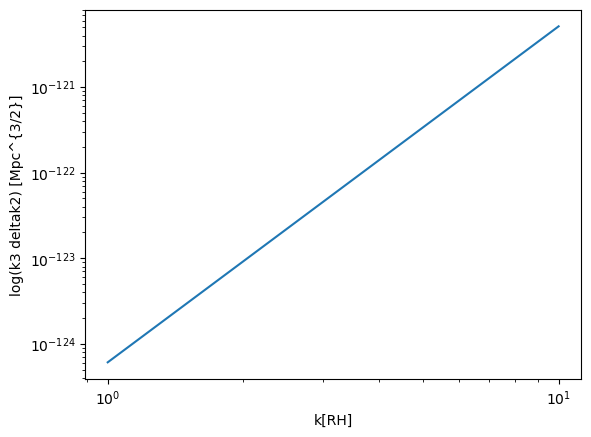

In [12]:
t_rh = -1.0e10
delta_k3 = []
analitical_delta_l = []
momenta_rh = np.geomspace(1.0e0, 1.0e9, 10)
for k_rh in momenta_rh:
    analitical_delta_l = []
    numerical_delta_l = []
    ## Since we have different momenta, they will have different time intervals where the addiabatic aproxximation is valid.This is why I am callign this get_adiab_time function
    k = k_rh / csq1d.RH

        ## Numerical
    delta_num = compute_delta_num(k_rh, t_rh) 
    numerical_delta_l.append(delta_num)
    spec = k**3 * delta_num**2
    delta_k3.append(spec)

    
plt.plot(momenta_rh, delta_k3)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('log(k3 deltak2) [Mpc^{3/2}]')
plt.xlabel('k[RH]')
   # plt.legend()
plt.show()

## We want to compute
\begin{align}
	\sigma(r)^2=\frac{1}{2 \pi^{2}} \int_{ki}^{kf} \mathrm{d} k_a~~   \delta^2_{k_a} k_a^2 W(kr)\\
 \sigma(r)^2=\frac{1}{2 \pi^{2}} \int_{ki}^{kf} \mathrm{d} k_a~~   \delta^2_{k_a} k_a^2 \left| 3 \frac{\sin(kr) - kr \cos(kr)}{(kr)^3}\right|^2\\
  \sigma(r)^2=\frac{9}{2 r^2 \pi^{2}} \int_{ki}^{kf} \mathrm{d} k_a~~   \delta^2_{k_a} \left| j_1(kr)\right|^2
	,\end{align}
 where $j_1$ is the first bessel function.

In [7]:
####Scales and time
t_integral = -1.0e-25
H_natural = csq1d.H_t(t_integral)  * conv_Hrh_Hn

kj_natural = csq1d.y_t(t_integral) * H_natural * math.sqrt(3.0/2.0) /  math.sqrt(csq1d.b)
kh_natural = csq1d.y_t(t_integral) *  H_natural
r_nat = math.pi /kj_natural

kj_rh = kj_natural * conv_knat_krh 
kh_rh = kh_natural * conv_knat_krh 
print(f'kj {kj_rh:22.15e} kh {kh_rh:22.15e}')
######Parameters for integrator object

lk = np.log((kj_rh - kh_rh)/2.0)


k_interval_center =  np.log(kh_rh) + lk/2.0


knots_int = 40
lnr = np.log(math.pi /kh_rh)
print(f"lk{lk:22.15e}")

kj  1.543097789436434e+11 kh  1.259934069111980e+08
lk 2.506826395982555e+01


In [8]:
fft = Ncm.FftlogSBesselJ.new(ell=1,lnr0=0.0 , lnk0=k_interval_center, Lk=lk, N=knots_int)
fft.set_q(0)
##This function sets the best scale for r to perform the integral
fft.set_best_lnr0()
np.exp(fft.get_lnr0())

4.951177013858863e-14

k 1.259934069111982e+08
k 2.357887267594843e+08
k 4.412637536346943e+08
k 8.257973269027264e+08
k 1.545427693760327e+09
k 2.892170607525708e+09
k 5.412515161212619e+09
k 1.012918127793955e+10
k 1.895612488933418e+10
k 3.547519399249310e+10
k 6.638959155165295e+10
k 1.242439397886871e+11
Adiabatic time not found
k 2.325147092101748e+11
Adiabatic time not found
k 4.351366359682596e+11
Adiabatic time not found
k 8.143308120374521e+11
Adiabatic time not found
k 1.523968833279181e+12
Adiabatic time not found
k 2.852011701479735e+12
Adiabatic time not found
k 5.337360297503678e+12
Adiabatic time not found
k 9.988533683290385e+12
Adiabatic time not found
k 1.869291177305195e+13
Adiabatic time not found
k 3.498260722088270e+13
Adiabatic time not found
k 6.546774642861059e+13
Adiabatic time not found
k 1.225187646929395e+14
Adiabatic time not found
k 2.292861526591950e+14
Adiabatic time not found
k 4.290945956973504e+14
Adiabatic time not found
k 8.030235141602599e+14
Adiabatic time not found
k

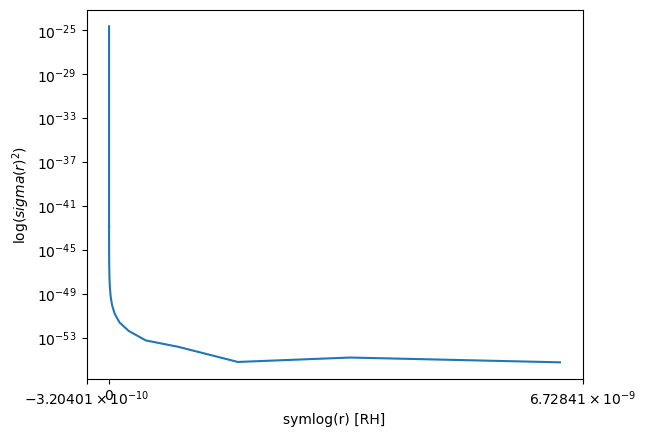

In [9]:
vec_k_knots = Ncm.Vector.new(knots_int) ## Empty vector for integrator object with the size of the knots
fft.get_lnk_vector(vec_k_knots) 

fft.eval_by_function(lambda k, _: integrand_numerical(k ,  t_integral), None)
fft.prepare_splines()
lnr_vec = fft.get_vector_lnr()
#This function computes the ingral. The argument defines if we want the derivative arg = (1,2,3), or just the integral arg = 0
integral_result = fft.get_vector_Gr(0)
var2_num_l = []
r_l = []
for i in range(0, knots_int):
    r = np.exp(lnr_vec.get(i))
    var2 = abs(integral_result.get(i))*9/(r**2)
    r_l.append(r)
    var2_num_l.append(var2)
    print(f'time = {t_integral}, var^2 = {var2}, r = {r: 22.15e}')
plt.plot(r_l, var2_num_l, label='var2')
plt.xlabel('symlog(r) [RH]')
plt.ylabel('log($ sigma(r)^2$)')
plt.xscale('symlog')
plt.yscale('log')
plt.show()


In [13]:
def do_beta(var, deltac):
    x = deltac / (math.sqrt(2.0) * var)
    return scipy.special.erfc(x)

In [14]:
def do_deltac(r,t_rh):
    H_eta = csq1d.H_t(t_rh) * (csq1d.y_t(t_rh) )
    return (1 / (r*H_eta))**2

In [16]:
deltac_list = []
r_scale_l = []
r_h = math.pi / kh_rh
r_j = math.pi / kj_rh
print(r_h, r_j)
deltac_kj_rh = do_deltac(r_j, t_integral)
deltac_kh_rh = do_deltac(r_h, t_integral)
print(deltac_kh_rh, deltac_kj_rh)

2.4934579757844252e-08 2.0358999119149524e-11
0.10132118364233779 151981.7754635066


In [17]:
deltac_interp = np.interp(r_l, [r_j, r_h], [deltac_kj_rh, deltac_kh_rh])

In [19]:
for i,delta in enumerate(deltac_interp):
    var = math.sqrt(var2_num_l[i])
    beta = do_beta(var, delta)
    print(f'For var = {var}, deltac = {delta}, beta = {beta}')

For var = 4.855656725704678e-13, deltac = 151981.7754635066, beta = 0.0
For var = 1.893696415703502e-13, deltac = 151981.7754635066, beta = 0.0
For var = 7.362270486580848e-14, deltac = 151981.7754635066, beta = 0.0
For var = 2.853160332715925e-14, deltac = 151981.7754635066, beta = 0.0
For var = 1.1020686830638317e-14, deltac = 151981.7754635066, beta = 0.0
For var = 4.2422180365003985e-15, deltac = 151981.7754635066, beta = 0.0
For var = 1.6270009570396362e-15, deltac = 151981.7754635066, beta = 0.0
For var = 6.215427896213552e-16, deltac = 151981.7754635066, beta = 0.0
For var = 2.364185312408627e-16, deltac = 151981.7754635066, beta = 0.0
For var = 8.949665310315675e-17, deltac = 151981.7754635066, beta = 0.0
For var = 3.369493406748348e-17, deltac = 151981.7754635066, beta = 0.0
For var = 1.2605911822606812e-17, deltac = 151981.7754635066, beta = 0.0
For var = 4.6806970560007935e-18, deltac = 151981.7754635066, beta = 0.0
For var = 1.7219710955111283e-18, deltac = 151981.775463506